# Multivariate Limit Theorems
This is a companion notebook for Chapter 3 of the thesis, modified from the paper, [*Central Limit Theorems via Analytic Combinatorics in Several Variables*](https://www.combinatorics.org/ojs/index.php/eljc/article/view/v31i2p27) by Stephen Melczer and Tiadora Ruza. 

This notebook allows one to compute a Local Central Limit theorem for a rational function satisfying the conditions of Theorem 46 in the thesis. We also apply the code to the examples, and perform computations corresponding to sections of the proof given in the thesis.

The other companion notebook for this chapter, available [on the GitHib page](https://github.com/Tia1300/masters_thesis/), gives code that takes a rational function and algorithmically checks whether its coefficients satisfy a Local Central Limit Theorem using Proposition 38 in the thesis. The other notebook thus works in a more general setting, but the code takes longer as it must prove the existence of minimal critical points.

## 1 - Theorem 22 Implementations
This section implements Theorem 22. Because the theorem may be invoked either for explicit examples or  parameterized families (with the dimension $d$ as a parameter) we give two implementations.

### Theorem 22 for Explicit Examples

In [12]:
# Helper functions for our main function

# Returns the phase Hessian matrix corresponding to the given input values
# P: 1 - H(1, 1, ..., 1, t)
# qₖ: list of qₖ(t)
# t: the variable representing t
# ρ: the smallest positive root of H(1, 1, ..., 1, t), 
#      where H(z_1, z_2, ..., z_d, t) is the denominator of the generating function being considered
# d: the number of z variables
def getHes(P, qₖ, t, ρ, d):
    H = matrix(SR,d)
    Pˡ = diff(P, t)
    Pˡˡ = diff(Pˡ, t)

    for i in range(d):
        for j in range(d):
            if i == j: 
                H[i,j] = (t*qₖ[j]^2*Pˡˡ-(2*qₖ[j]*diff(qₖ[j], t)*t-qₖ[j]^2)*Pˡ-qₖ[j]*t*Pˡ^2)/(t^2*Pˡ^3)
            else:
                H[i,j] = (t*qₖ[i]*qₖ[j]*Pˡˡ-(qₖ[j]*diff(qₖ[i], t)*t+qₖ[i]*diff(qₖ[j], t)*t-qₖ[i]*qₖ[j])*Pˡ)/(t^2*Pˡ^3)
    
    return H.subs(t == ρ)

# Returns the determinant of the phase Hessian matrix corresponding to the given input values
# P: 1 - H(1, 1, ..., 1, t)
# qₖ: list of qₖ(t)
# qₜ: q(t)
# t: the variable representing t
# ρ: the smallest positive root of H(1, 1, ..., 1, t), 
#      where H(z_1, z_2, ..., z_d, t) is the denominator of the generating function being considered
# d: the number of z variables
def getHesDet(P, qₖ, qₜ, t, ρ, d):
    Pˡ = diff(P, t)
    Pˡˡ = diff(Pˡ, t)
    
    deter = (-1)^d*mul(qₖ)*((qₜ-1)*(t*Pˡˡ+Pˡ+t*sum(diff(qₖ[k], t)^2/qₖ[k] for k in range(d)))+diff(qₜ, t)^2*t)
    deter /= Pˡ^(d+2)*t^(d+1)
    
    return deter.subs(t == ρ)

# Returns Aₙ, m, νₙ as defined in the paper, as well as the phase Hessian
# While this does verify the majority of requirements for a LCLT, we make the following caveats:
#       1. We do not check that the coefficients of q(t) are non-negative.
#       2. We assume that q(t) is a complex-valued analytic function for |t|<= ρ.
#       3. We attempt to certify aperiodicity of q(t), but do not prove if something is periodic. 
#          If the certification for aperiodicity fails, a warning is printed.
#       4. We assume that the variable orderings correspond to qₖ and that the last variable is the one 
#          representing t.
# G: the numerator of the multivariate generating function
# qₖ: list of the qₖ(t)
# qₜ: q(t)
# vars: the variables used in the multivariate generating function (assume that the ordering corresponds to 
#       qₖ and that the last one is the variable representing t)
def getLCLT(G, qₖ, qₜ, vars):
    var('n')
    
    # condition checking
    R = PolynomialRing(QQbar, vars)
    for q in qₖ:
        try:
            R(q)
        except:
            print("Error: Not all qₖ are polynomials.")
            return
        if q == 0:
            print("Error: Not all polynomials in qₖ are non-zero.")
            return
        if q.subs(vars[-1] == 0) != 0:
            print("Error: Not all polynomials in qₖ vanish at the origin.")
            return
        if not(all(coeff[0] >= 0 for coeff in q.coefficients(vars[-1]))):
            print("Error: Not all polynomials in qₖ have non-negative coefficients.")
            return
    if qₜ.subs(vars[-1] == 0) != 0:
        print("Error: q(t) does not vanish at the origin.")
        return
    if gcd([coeff[1] for coeff in (qₜ.series(vars[-1], 101)).coefficients(vars[-1])]) != 1:
        print("Warning: Could not verify aperiodicity.")
    
    # find ρ
    P =  1 - qₜ - sum(qₖ)
    sols = solve(P == 0, vars[-1])
    ρlist = [sol.rhs() for sol in sols if sol.rhs() > 0]
    ρ = min(ρlist)
    
    # condition checking
    Gsub = G.subs([var == 0 for var in vars[:-1]] + [vars[-1] == ρ])
    if Gsub == 0:
        print("Error: G(1, 1, ..., 1, ρ) = 0.")
        return
    
    # find required values
    d = len(vars)-1
    
    hessian = getHes(P, qₖ, vars[-1], ρ, d)
    detHess = getHesDet(P, qₖ, qₜ, vars[-1], ρ, d)
    
    Pˡ = diff(P, vars[-1])
    
    s = matrix(list(var('s', n=d)))

    # using expressions from paper to find Aₙ, m ans νₙ
    Aₙ = ρ^(-n)*n^(-d/2)*Gsub/(-ρ*Pˡ.subs(vars[-1] == ρ)*(2*pi)^(d/2)*sqrt(detHess))
    
    m = matrix(RR,1,d)
    for k in range(d):
        m[0,k] = -qₖ[k].subs(vars[-1] == ρ)/(ρ*Pˡ.subs(vars[-1] == ρ))

    νₙ = exp((-((s - n*m)*hessian.inverse()*(s-n*m).transpose())[0,0])/(2*n))
    
    return Aₙ, m, νₙ, hessian

### Theorem 22 with Parameterized Dimension

In [13]:
# Helper functions for our main function

# Returns the entry patterns of the phase Hessian matrix corresponding to the given input values
# qₖ: the polynomial qₖ as a function of k
# t: the variable representing t
# ρ: either the variable representing or the value of ρ
# Pˡ: either the variable representing or the value of the derivative P'
# Pˡˡ: either the variable representing or the value of the second derivative P''
def getHesEntries(qₖ, t, ρ, Pˡ, Pˡˡ):
    var('i j')
    
    qᵢ = qₖ.subs(k == i)
    qⱼ = qₖ.subs(k == j)

    Hⱼⱼ = (t*qⱼ^2*Pˡˡ-(2*qⱼ*diff(qⱼ, t)*t-qⱼ^2)*Pˡ-qⱼ*t*Pˡ^2)/(t^2*Pˡ^3)
    Hᵢⱼ = (t*qᵢ*qⱼ*Pˡˡ-(qⱼ*diff(qᵢ, t)*t+qᵢ*diff(qⱼ, t)*t-qᵢ*qⱼ)*Pˡ)/(t^2*Pˡ^3)
    
    return Hⱼⱼ.subs(t == ρ), Hᵢⱼ.subs(t == ρ)

# Returns the determinant of the phase Hessian matrix corresponding to the given input values
# qₖ: the polynomial qₖ as a function of k
# qₜ: q(t)
# t: the variable representing t
# ρ: either the variable representing or the value of ρ
# d: variable representing the number of z variables
# Pˡ: either the variable representing or the value of Pˡ
# Pˡˡ: either the variable representing or the value of Pˡˡ
def getSymHesDet(qₖ, qₜ, t, ρ, d, Pˡ, Pˡˡ):
    
    deter = (-1)^d*product(qₖ, k, 1, d)*((qₜ-1)*(t*Pˡˡ+Pˡ+t*sum(diff(qₖ, t)^2/qₖ, k, 1, d))+diff(qₜ, t)^2*t)
    deter /= Pˡ^(d+2)*t^(d+1)
    
    return deter.subs(t == ρ)

# Returns Aₙ as defined in the paper and the entries for m and the phase hessian (all in terms of the given 
#         Pˡ, Pˡˡ, ρ and d.
# While this does verify the majority of requirements for a LCLT, we make the following caveats:
#       1. We do not check that the coefficients of q(t) are non-negative.
#       2. We assume that the qᵢ(t) are indeed polynomials and that q(t) is a complex-valued 
#          analytic function for |t|<= ρ.
#       3. We attempt to certify aperiodicity of q(t), but do not prove if something is periodic. 
#          If the certification for aperiodicity fails, a warning is printed.
#       4. We assume that the variable orderings correspond to qₖ and that the last variable is the one 
#          representing t.
# Gsub: the numerator of the multivariate generating function where all variables aside from t are set to 1
# qₖ: the polynomial qₖ as a function of k
# qₜ: q(t)
# t: the variable representing t
# d: the variable representing d
# k: the variable representing k
# ρ: either the variable representing or the value of ρ
# d: variable representing the number of z variables
# Pˡ: either the variable representing or the value of Pˡ
# Pˡˡ: either the variable representing or the value of Pˡˡ
def getSymLCLT(Gsub, qₖ, qₜ, t, d, k, ρ, Pˡ, Pˡˡ):
    var('s m n')
    
    # condition checking
    if qₖ == 0:
        print("Error: qₖ pattern is not non-zero.")
        return
    if qₖ.subs(t == 0) != 0:
        print("Error: qₖ pattern does not vanish at the origin.")
        return
    if qₜ.subs(t == 0) != 0:
        print("Error: q(t) does not vanish at the origin.")
        return
    if Gsub.subs(t == ρ) == 0:
        print("Error: G(1, 1, ..., 1, ρ) = 0.")
        return
    
    # phase hessian and determinant
    Hⱼⱼ, Hᵢⱼ = getHesEntries(qₖ, t, ρ, Pˡ, Pˡˡ)
    detHess = getSymHesDet(qₖ, qₜ, t, ρ, d, Pˡ, Pˡˡ)
    
    # Aₙ and m pattern
    Aₙ = ρ^(-n)*n^(-d/2)*Gsub.subs(t == ρ)/(-ρ*Pˡ.subs(t == ρ)*(2*pi)^(d/2)*sqrt(detHess))
    
    mpat = -qₖ.subs(t == ρ)/(ρ*Pˡ.subs(t == ρ))
    
    return Aₙ.canonicalize_radical(), mpat.canonicalize_radical(), Hᵢⱼ.canonicalize_radical(), Hⱼⱼ.canonicalize_radical()

## 2 - Examples from the Paper
This section uses our implementations on some examples from the paper.

### 1.1 Motivating Example: Permutations with Restricted Cycles
Finding an LCLT for permutations with restricted cycles.

In [14]:
# Set up variables
var('t k d ρ')
Pˡ, Pˡˡ = SR.symbol("Pˡ"), SR.symbol("Pˡˡ")

# Get the limit theorem for parameterized dimension d
Aₙ, mpat, Hᵢⱼ, Hⱼⱼ = getSymLCLT(1, t^(k+1), t, t, d, k, ρ, Pˡ, Pˡˡ)
show('Aₙ = ', Aₙ)
show('mpattern = ', mpat)
show('Hᵢⱼ =', Hᵢⱼ)
show('Hⱼⱼ = ', Hⱼⱼ)

'Aₙ = ' -sqrt(Pˡ^d)*(ρ - 1)*sqrt(ρ^d)/(sqrt(Pˡˡ*ρ^4 + (Pˡ - 3*Pˡˡ)*ρ^3 - (3*Pˡ - 3*Pˡˡ - 1)*ρ^2 + ((d^2 + 2*d + 1)*ρ^3 - (2*d^2 + 6*d + 3)*ρ^2 + (d^2 + 4*d + 4)*ρ)*ρ^d + (3*Pˡ - Pˡˡ - 3)*ρ - Pˡ)*2^(1/2*d)*sqrt((-1)^d)*pi^(1/2*d)*n^(1/2*d)*ρ^(n + 1/2)*sqrt(product(ρ^(k + 1), k, 1, d)))

'mpattern = ' -ρ^k/Pˡ

'Hᵢⱼ =' -(Pˡ*i + Pˡ*j - Pˡˡ*ρ + Pˡ)*ρ^(i + j)/Pˡ^3

'Hⱼⱼ = ' -(Pˡ^2*ρ^j + (2*Pˡ*j - Pˡˡ*ρ + Pˡ)*ρ^(2*j))/Pˡ^3

#### $[t^{150}]P(z_1, z_2, t)$
Plotting the coefficients of $[t^{150}]P(z_1, z_2, t)$ divided by the maximum coefficient.

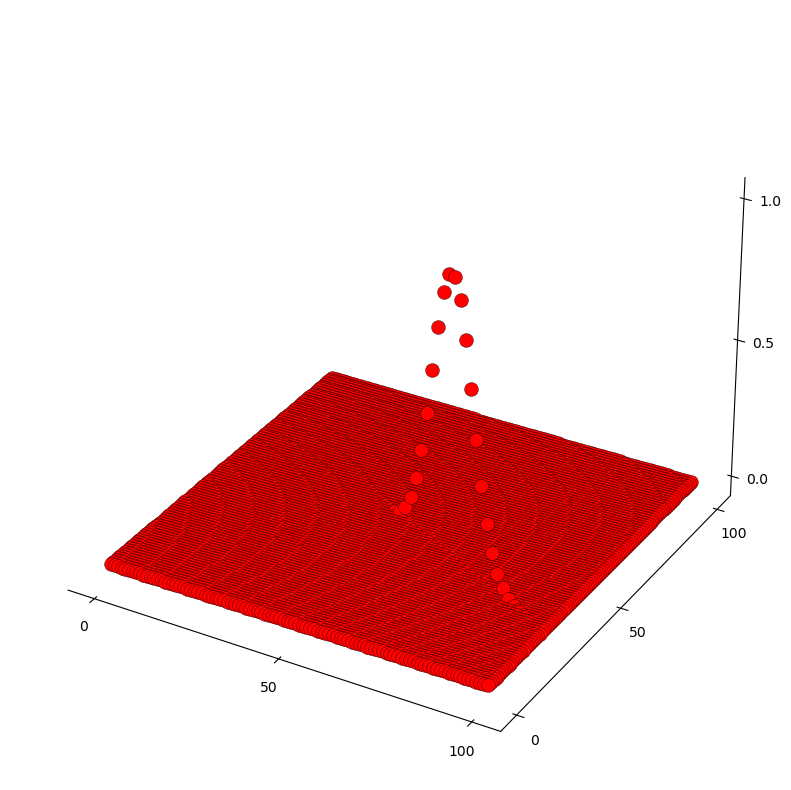

In [4]:
import matplotlib.pyplot as plt
var('z1,z2,t')

# Define denominator H(x,t) and the polynomial h = H(1,...,1,t)
H = 1 - z1*t - z2*t^2
F = 1/H

# Set index to plot
N = 150

# Get series expansion
ser = ZZ[z1,z2](F.taylor((z1,0),(z2,0),(t,0),3*N+1).coefficient(t,N))

# find maximum value
maxval = max(ser.coefficients())

# plot
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(projection='3d')

ax.grid(False)

ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.set_zticks([0, 0.5, 1])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


for i in range(0,101):
    for j in range(0,101):
        ax.scatter(i,j,ser[i,j]/maxval, marker='o', color='red', edgecolor='black', s=100, linewidth=0.25)

plt.show()

#### $[t^{150}]P(1, z_2, t)$
Plotting the coefficients of $[t^{150}]P(1, z_2, t)$ compared to their limiting normal distribution.

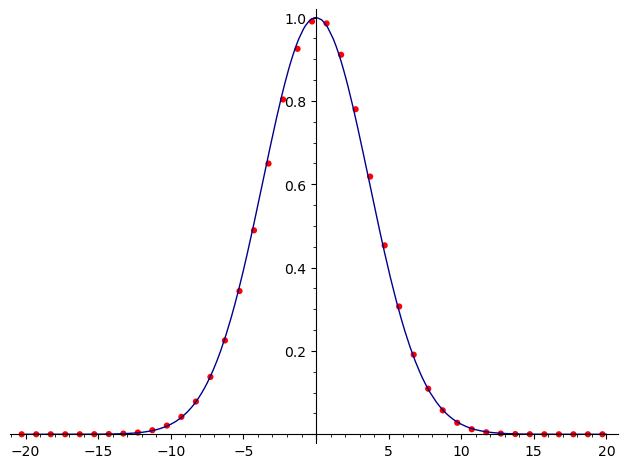

In [5]:
# Define denominator H(x,t) and the polynomial h = H(1,...,1,t)
var('n,z2,t')
H = 1 - t - z2*t^2
F = 1/H

# Set index to plot
N = 150

# get limiting distribution
Aₙ, m, νₙ, hes = getLCLT(1, [t^2], t, [z2, t])
norm = exp(-N*((s0/N)^2/hes[0,0]/2))

# Get index of maximum coefficient
m0 = round(m[0, 0]*N)

# Get series expansion
ser = ZZ[z2](F.taylor((z2,0),(t,0),2*N+1).coefficient(t,N))

# Plot series coefficients of [t^n]F(x,t) compared to limit distribution, shifted to have the maximum at the origin
pt = point([[k-m0/N,ser[m0+k]/Aₙ.subs(n==N)] for k in range(-20,21)], color='red', size=20)
pt += plot(norm,s0,-20,20,color='darkblue')
pt

### 1.3 Additional Examples
Examples applying Theorem 22 to strings with tracked letters, compositions with tracked summands and $n$-colour compositions with tracked summands.

#### Strings with Tracked Letters
Finding an LCLT for strings with tracked letters.

While most requirements of getSymLCLT can be found directly from the generating function, $\rho$, $P'(\rho)$ and $P''(\rho)$ require minor calculations. 

By definition, $P(t) = 1-\ell t$. 

Thus, if $t = \frac{1}{\ell}$, $P(t) = 0$ and hence, $\rho = \frac{1}{\ell}$. 

$P'(t) = -\ell$ and $P''(t) = 0$, so $P'(\rho) = -\ell$ and $P''(\rho) = 0$. 

It is these values that we use in our call to getSymLCLT.

In [6]:
var('t k d l')
Aₙ, mpat, Hᵢⱼ, Hⱼⱼ = getSymLCLT(1, t, (l-d)*t, t, d, k, 1/l, -l, 0)
show('Aₙ = ', Aₙ)
show('mpattern = ', mpat)
show('Hᵢⱼ = ', Hᵢⱼ)
show('Hⱼⱼ = ', Hⱼⱼ)

'Aₙ = ' sqrt((-l)^d)*l^(n + 1/2)/(2^(1/2*d)*sqrt((-1)^d)*pi^(1/2*d)*sqrt(-d + l)*n^(1/2*d))

'mpattern = ' 1/l

'Hᵢⱼ = ' -1/l^2

'Hⱼⱼ = ' (l - 1)/l^2

##### Classical Central Limit Theorem
Recovering the Classical Central Limit Theorem, a subcase of strings with tracked letters.

In [15]:
var('z t')
Aₙ, m, νₙ, hes = getLCLT(1, [t], t, [z, t])
show('Aₙ = ', Aₙ)
show('m = ', m)
show('νₙ = ', νₙ)

'Aₙ = ' sqrt(2)/(sqrt(pi)*(1/2)^n*sqrt(n))

'm = ' [0.500000000000000]

'νₙ = ' e^(-1/2*(-0.500000000000000*n + s0)*(-2.00000000000000*n + 4*s0)/n)

#### Compositions with Tracked Summands
Finding an LCLT for compositions with tracked summands.

As with our strings with tracked letters example, while most requirements of getSymLCLT can be found directly from the generating function, $\rho$, $P'(\rho)$ and $P''(\rho)$ require minor calculations. 

By definition, $P(t) = 1-\frac{t}{1-t}$. 

Thus, if $t = \frac{1}{2}$, $P(t) = 0$ and hence, $\rho = \frac{1}{2}$. 

$P'(t) = -\frac{1}{(1-t)^2}$ and $P''(t) = -\frac{2}{(1-t)^3}$, so $P'(\rho) = -4$ and $P''(\rho) = -16$. 

It is these values that we use in our call to getSymLCLT.

In [8]:
var('t k d')
Aₙ, mpat, Hᵢⱼ, Hⱼⱼ = getSymLCLT(1, t^k, t^(d+1)/(1-t), t, d, k, 1/2, -4, -16)
show('Aₙ = ', Aₙ)
show("Since ", product(1/2^k, k, 1, d) == 1/2^(1/2*d^2 + 1/2*d), ",")
show('Aₙ = ', (-2^(d + n + 2)/(sqrt((d^2 + 4*d + 6)*2^d - 2)*pi^(1/2*d)*(-4)*n^(1/2*d)*sqrt(1/2^(1/2*d^2 + 1/2*d)))).canonicalize_radical())
show('mpattern = ', mpat)
show('Hᵢⱼ = ', Hᵢⱼ)
show('Hⱼⱼ = ', Hⱼⱼ)

'Aₙ = ' 2^(d + n)/(sqrt((d^2 + 4*d + 6)*2^d - 2)*pi^(1/2*d)*n^(1/2*d)*sqrt(product(1/(2^k), k, 1, d)))

'Since ' (1/product(2^k, k, 1, d)) == (1/(2^(1/2*d^2 + 1/2*d))) ','

'Aₙ = ' 2^(1/4*d^2 + 5/4*d + n)/(sqrt((d^2 + 4*d + 6)*2^d - 2)*pi^(1/2*d)*n^(1/2*d))

'mpattern = ' 2^(-k - 1)

'Hᵢⱼ = ' -2^(-i - j - 2)*(i + j - 3)

'Hⱼⱼ = ' (2^(j + 1) - 2*j + 3)*2^(-2*j - 2)

#### $[t^{100}]\frac{1}{1-z_1t-\frac{t^2}{1-t}}$
Plotting the coefficients of $[t^{100}]\frac{1}{1-z_1t-\frac{t^2}{1-t}}$ divided by the projected maximum coefficient compared to their limiting normal distribution.

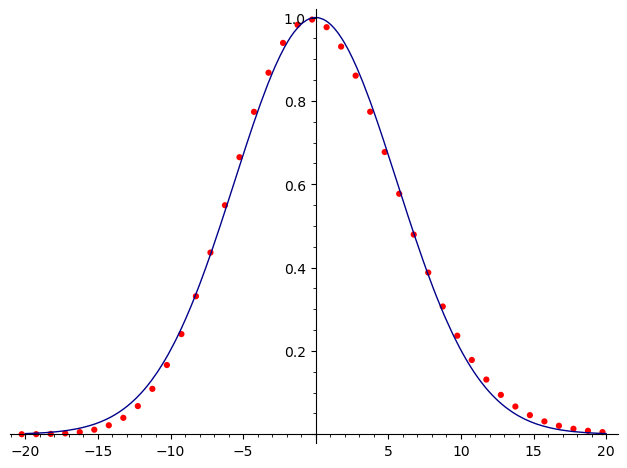

In [9]:
# Define denominator H
var('n,z1,t')
H = 1 - z1*t - t^2/(1-t)
F = 1/H

# Set index to plot
N = 100

# Get limiting distribution
Aₙ, m, νₙ, hes = getLCLT(1, [t], t^2/(1-t), [z1, t])
norm = exp(-N*((s0/N)^2/hes[0,0]/2))

# Get index of maximum coefficient
m0 = round(m[0,0]*N)

# Get series expansion
ser = ZZ[z1](F.taylor((z1,0),(t,0),2*N+1).coefficient(t,N))

# Plot series coefficients of [t^n]F(x,t) compared to limit distribution
pt = point([[k-m0/N,ser[m0+k]/Aₙ.subs(n==N)] for k in range(-20,21)], color='red', size=20)
pt += plot(norm,s0,-20,20,color='darkblue')
pt

#### $[t^{100}]\frac{1}{1-z_1t-z_2t^2-\frac{t^3}{1-t}}$
Plotting the coefficients of $[t^{100}]\frac{1}{1-z_1t-z_2t^2-\frac{t^3}{1-t}}$ divided by the projected maximum coefficient.

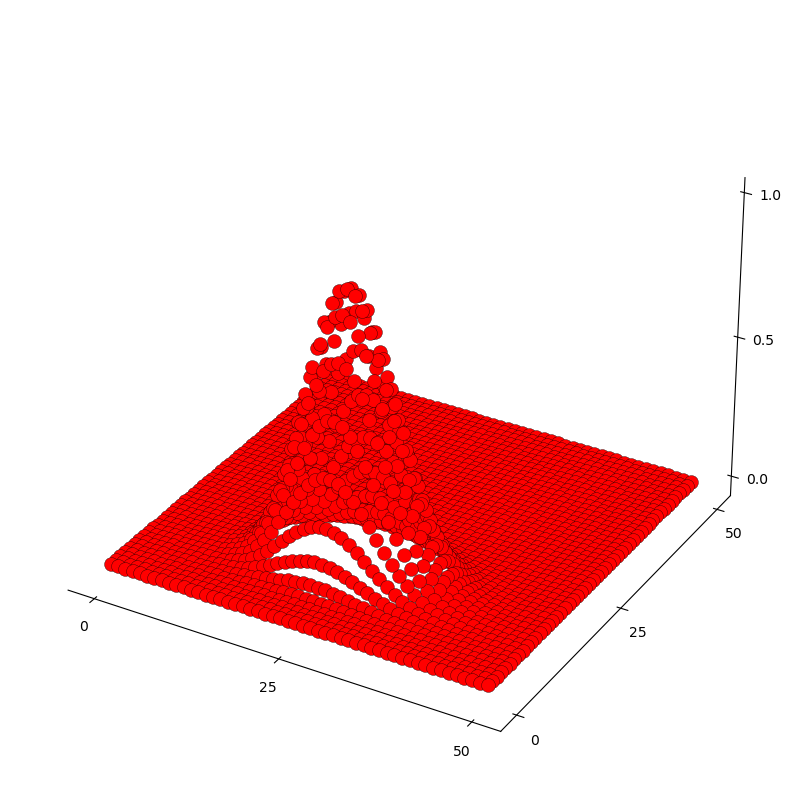

In [16]:
# Define denominator H
var('n,z1,z2,t')
H = 1 - z1*t - z2*t^2 - t^3/(1-t)
F = 1/H

# Set index to plot
N = 100

# get limiting distribution
Aₙ, m, νₙ, hes = getLCLT(1, [t, t^2], t^3/(1-t), [z1, z2, t])

# Get index of maximum coefficient
m0 = round(m[0,0]*N)

# Get series expansion
ser = ZZ[z1,z2](F.taylor((z1,0),(z2,0),(t,0),3*N+1).coefficient(t,N))

# plot
import matplotlib.pyplot as plt
 
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(projection='3d')

ax.grid(False)

ax.set_xticks([0, 25,50])
ax.set_yticks([0, 25,50])
ax.set_zticks([0, 0.5, 1])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


for i in range(0,51):
    for j in range(0,51):
        ax.scatter(i,j,ser[i,j]/Aₙ.subs(n==N), marker='o', color='red', edgecolor='black', s=100, linewidth=0.25)

plt.show()

#### $n$-Colour Compositions with Tracked Summands
Finding an LCLT for $n$-colour compositions with tracked summands.

In [11]:
var('t k d ρ')
Pˡ = SR.symbol('Pˡ')
Pˡˡ = SR.symbol('Pˡˡ')
Aₙ, mpat, Hᵢⱼ, Hⱼⱼ = getSymLCLT(1, k*t^k, d*t^(d+1)/(1-t) + t^(d+1)/(1-t)^2, t, d, k, ρ, Pˡ, Pˡˡ)
show('Aₙ = ', Aₙ)
show('mpattern = ', mpat)
show('Hᵢⱼ = ', Hᵢⱼ)
show('Hⱼⱼ = ', Hⱼⱼ)

'Aₙ = ' -(ρ^3 - 3*ρ^2 + 3*ρ - 1)*sqrt(Pˡ^d)*sqrt(ρ^d)/(sqrt(-Pˡˡ*ρ^7 - (Pˡ - 6*Pˡˡ)*ρ^6 + 3*(2*Pˡ - 5*Pˡˡ)*ρ^5 - (15*Pˡ - 20*Pˡˡ + 1)*ρ^4 + (20*Pˡ - 15*Pˡˡ - 2)*ρ^3 - 3*(5*Pˡ - 2*Pˡˡ - 2)*ρ^2 - ((d^2 - d)*ρ^4 - 2*(d^2 + d)*ρ^3 + (d^2 + 3*d + 2)*ρ^2)*ρ^(2*d) - (Pˡˡ*d*ρ^7 + ((Pˡ - 5*Pˡˡ)*d - Pˡˡ)*ρ^6 + (d^3 - 5*(Pˡ - 2*Pˡˡ)*d - Pˡ + 4*Pˡˡ)*ρ^5 - (5*d^3 - 2*(5*Pˡ - 5*Pˡˡ + 2)*d + 3*d^2 - 4*Pˡ + 6*Pˡˡ + 1)*ρ^4 + (10*d^3 - (10*Pˡ - 5*Pˡˡ + 3)*d + 12*d^2 - 6*Pˡ + 4*Pˡˡ - 3)*ρ^3 - d^3 - (10*d^3 - (5*Pˡ - Pˡˡ - 3)*d + 18*d^2 - 4*Pˡ + Pˡˡ - 2)*ρ^2 - 3*d^2 + (5*d^3 - (Pˡ - 5)*d + 12*d^2 - Pˡ - 3)*ρ - 3*d - 1)*ρ^d + (6*Pˡ - Pˡˡ - 2)*ρ - Pˡ - 1)*2^(1/2*d)*sqrt((-1)^d)*pi^(1/2*d)*n^(1/2*d)*ρ^(n + 1/2)*sqrt(factorial(d))*sqrt(product(ρ^k, k, 1, d)))

'mpattern = ' -k*ρ^(k - 1)/Pˡ

'Hᵢⱼ = ' -(Pˡ*i*j^2 - Pˡˡ*i*j*ρ + (Pˡ*i^2 - Pˡ*i)*j)*ρ^(i + j - 2)/Pˡ^3

'Hⱼⱼ = ' -(Pˡ^2*j*ρ^(j + 1) + (2*Pˡ*j^3 - Pˡˡ*j^2*ρ - Pˡ*j^2)*ρ^(2*j))/(Pˡ^3*ρ^2)

#### $[t^{100}]\frac{1}{1-z_1t-\frac{t^2}{1-t}-\frac{t^2}{(1-t)^2}}$
Plotting the coefficients of $[t^{100}]\frac{1}{1-z_1t-\frac{t^2}{1-t}-\frac{t^2}{(1-t)^2}}$ divided by the projected maximum coefficient compared to their limiting normal distribution.

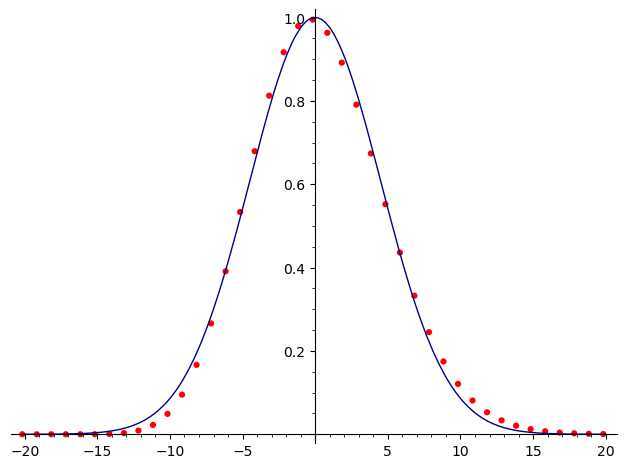

In [17]:
# Define denominator H
var('n,z1,t')
H = 1 - z1*t - t^2/(1-t) - t^2/(1-t)^2
F = 1/H

# Set index to plot
N = 100

# get limiting distribution
Aₙ, m, νₙ, hes = getLCLT(1, [t], t^2/(1-t) + t^2/(1-t)^2, [z1, t])
norm = exp(-N*((s0/N)^2/hes[0,0]/2))

# Get index of maximum coefficient
m0 = round(m[0,0]*N)

# Get series expansion
ser = ZZ[z1](F.taylor((z1,0),(t,0),2*N+1).coefficient(t,N))

# Plot series coefficients of [t^n]F(x,t) compared to limit distribution
pt = point([[k-m0/N,ser[m0+k]/Aₙ.subs(n==N)] for k in range(-20,21)], color='red', size=20)
pt += plot(norm,s0,-20,20,color='darkblue')
pt

#### $[t^{100}]\frac{1}{1-z_1t-2z_2t^2-\frac{2t^3}{1-t}-\frac{t^3}{(1-t)^2}}$
Plotting the coefficients of $[t^{100}]\frac{1}{1-z_1t-2z_2t^2-\frac{2t^3}{1-t}-\frac{t^3}{(1-t)^2}}$ divided by the projected maximum coefficient.

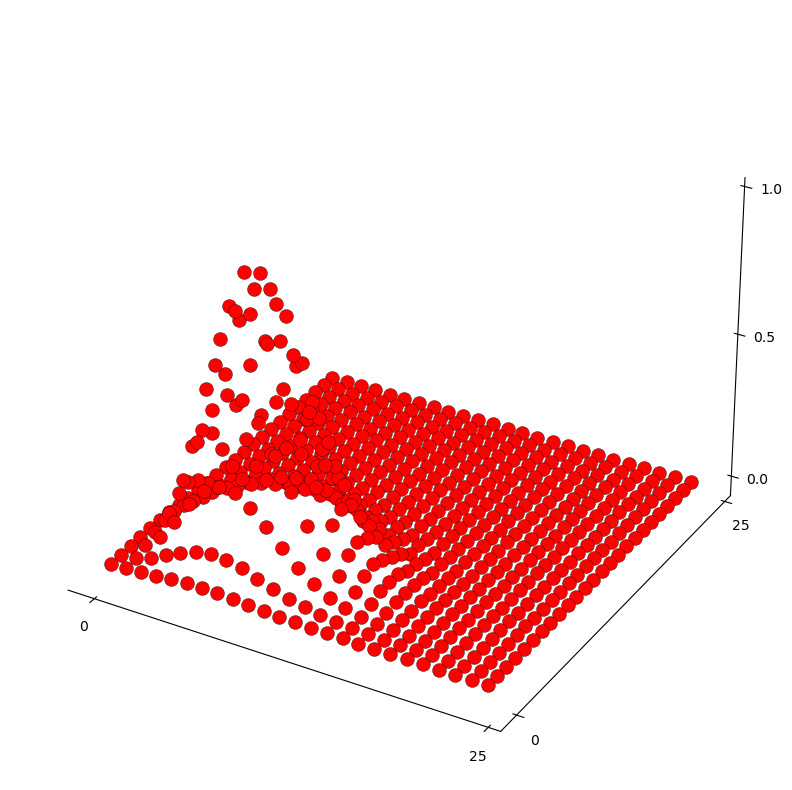

In [18]:
# Define denominator H
var('n,z1,z2,t')
H = 1 - z1*t - 2*z2*t^2 - 2*t^3/(1-t) - t^3/(1-t)^2
F = 1/H

# Set index to plot
N = 40

# get limiting distribution
Aₙ, m, νₙ, hes = getLCLT(1, [t, 2*t^2], 2*t^3/(1-t) + t^3/(1-t)^2, [z1, z2, t])

# Get index of maximum coefficient
m0 = round(m[0,0]*N)

# Get series expansion
ser = ZZ[z1,z2](F.taylor((z1,0),(z2,0),(t,0),3*N+1).coefficient(t,N))

# plot
import matplotlib.pyplot as plt
 
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(projection='3d')

ax.grid(False)

ax.set_xticks([0, 25,50])
ax.set_yticks([0, 25,50])
ax.set_zticks([0, 0.5, 1])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


for i in range(0,25):
    for j in range(0,25):
        ax.scatter(i,j,ser[i,j]/Aₙ.subs(n==N), marker='o', color='red', edgecolor='black', s=100, linewidth=0.25)

plt.show()

## 3 - Proof of Theorem 22
Calculations required in the paper for the proof of Theorem 22.

#### Define all variables

In [14]:
# define variables
# sums
Aⱼ = SR.symbol("Aⱼ")
Bⱼ = SR.symbol("Bⱼ")
Cⱼ = SR.symbol("Cⱼ")
Dⱼ = SR.symbol("Dⱼ")

# ρ, P'(ρ), P''(ρ)
ρ = SR.symbol("ρ")
Pˡ = SR.symbol("Pˡ")
Pˡˡ = SR. symbol("Pˡˡ")

# qⱼ(ρ), qᵢ(ρ), qₐ(ρ)
qⱼ = SR.symbol("qⱼ")
qᵢ = SR.symbol("qᵢ")
qₐ = SR.symbol("qₐ")

# q'ⱼ(ρ), q'ᵢ(ρ), q'ₐ(ρ)
qˡⱼ = SR.symbol("qˡⱼ")
qˡᵢ = SR.symbol("qˡᵢ")
qˡₐ = SR.symbol("qˡₐ")

#### Case 1 of Proof
The following provides the Sage components required for the proof of Case 1: $j > i$.

In [15]:
# when i \neq a
Hᵢₐ = (ρ*qᵢ*qₐ*Pˡˡ-(qₐ*qˡᵢ*ρ+qᵢ*qˡₐ*ρ-qᵢ*qₐ)*Pˡ)/(ρ^2*Pˡ^3)

# when a < j
gₐⱼ = Pˡ + Pˡˡ*ρ - ρ*(qˡₐ/qₐ + qˡⱼ/qⱼ)*(Pˡ+Bⱼ-qˡₐ)+ρ*(Dⱼ - qˡₐ^2/qₐ)+(ρ*qˡₐ*qˡⱼ)/(qₐ*qⱼ)*(Aⱼ-qₐ)
rⱼ =  Pˡ^2*ρ - Pˡˡ*ρ*Aⱼ + 2*Pˡ*ρ*Bⱼ - Pˡ*Aⱼ - ρ*(Aⱼ*Dⱼ - Bⱼ^2)
Uₐⱼ = (qⱼ*gₐⱼ)/rⱼ

HᵢₐUₐⱼ = Hᵢₐ*Uₐⱼ

αᵢⱼ = (Pˡ*qⱼ - qˡⱼ*Aⱼ + qⱼ*Bⱼ)*Pˡ*qᵢ*ρ^2
βᵢⱼ = (Pˡ*(qˡⱼ*ρ-qⱼ) - Pˡˡ*qⱼ*ρ + qˡⱼ*ρ*Bⱼ - qⱼ*ρ*Dⱼ)*(Pˡ*(qˡᵢ*ρ-qᵢ)- Pˡˡ*qᵢ*ρ)
γᵢⱼ = (qˡⱼ*qᵢ+qˡᵢ*qⱼ)*ρ^2*Pˡ^2 - 2*(Pˡ+Pˡˡ*ρ)*ρ*Pˡ*qᵢ*qⱼ + (Pˡˡ*qˡⱼ*qᵢ*ρ - Pˡ*qˡᵢ*qˡⱼ*ρ + Pˡ*qˡⱼ*qᵢ)*ρ*Aⱼ + (qˡⱼ*qᵢ*ρ + qˡᵢ*qⱼ*ρ - qᵢ*qⱼ)*ρ*Pˡ*Bⱼ - Pˡˡ*qᵢ*qⱼ*ρ^2*Bⱼ - Pˡ*qᵢ*qⱼ*ρ^2*Dⱼ

HUcheck = (αᵢⱼ*(qˡₐ^2/qₐ) + βᵢⱼ*qₐ + γᵢⱼ*qˡₐ)/(ρ^2*Pˡ^3*rⱼ)

show((HUcheck-HᵢₐUₐⱼ).canonicalize_radical())

0

In [16]:
# sum HᵢₐUₐⱼ
sumHᵢₐUₐⱼ = (αᵢⱼ*(Dⱼ-qˡᵢ^2/qᵢ) + βᵢⱼ*(Aⱼ-qᵢ) + γᵢⱼ*(Bⱼ-qˡᵢ))/(ρ^2*Pˡ^3*rⱼ)

# HᵢᵢUᵢⱼ, i < j
Hᵢᵢ = (ρ*qᵢ^2*Pˡˡ-(2*qᵢ*qˡᵢ*ρ-qᵢ^2)*Pˡ-qᵢ*ρ*Pˡ^2)/(ρ^2*Pˡ^3)

gᵢⱼ = Pˡ + Pˡˡ*ρ - ρ*(qˡᵢ/qᵢ + qˡⱼ/qⱼ)*(Pˡ+Bⱼ-qˡᵢ)+ρ*(Dⱼ - qˡᵢ^2/qᵢ)+(ρ*qˡᵢ*qˡⱼ)/(qᵢ*qⱼ)*(Aⱼ-qᵢ)
Uᵢⱼ = (qⱼ*gᵢⱼ)/rⱼ

HᵢᵢUᵢⱼ = Hᵢᵢ*Uᵢⱼ


# Hᵢⱼ, i < j
Hᵢⱼ = (ρ*qᵢ*qⱼ*Pˡˡ-(qⱼ*qˡᵢ*ρ+qᵢ*qˡⱼ*ρ-qᵢ*qⱼ)*Pˡ)/(ρ^2*Pˡ^3)

# Total
total = sumHᵢₐUₐⱼ + HᵢᵢUᵢⱼ + Hᵢⱼ
show(total.canonicalize_radical())

0

#### Case 2 of Proof
The following provides the Sage components required for the proof of Case 2: $i > j$.

In [17]:
# when j \neq a
Hⱼₐ = (ρ*qⱼ*qₐ*Pˡˡ-(qₐ*qˡⱼ*ρ+qⱼ*qˡₐ*ρ-qⱼ*qₐ)*Pˡ)/(ρ^2*Pˡ^3)

# when a < j
gₐⱼ = Pˡ + Pˡˡ*ρ - ρ*(qˡₐ/qₐ + qˡⱼ/qⱼ)*(Pˡ+Bⱼ-qˡₐ)+ρ*(Dⱼ - qˡₐ^2/qₐ)+(ρ*qˡₐ*qˡⱼ)/(qₐ*qⱼ)*(Aⱼ-qₐ)
rⱼ =  Pˡ^2*ρ - Pˡˡ*ρ*Aⱼ + 2*Pˡ*ρ*Bⱼ - Pˡ*Aⱼ - ρ*(Aⱼ*Dⱼ - Bⱼ^2)
Uₐⱼ = (qⱼ*gₐⱼ)/rⱼ

HⱼₐUₐⱼ = Hⱼₐ*Uₐⱼ

αⱼⱼ = (Pˡ*qⱼ - qˡⱼ*Aⱼ + qⱼ*Bⱼ)*Pˡ*qⱼ*ρ^2
βⱼⱼ = (Pˡ*(qˡⱼ*ρ-qⱼ) - Pˡˡ*qⱼ*ρ + qˡⱼ*ρ*Bⱼ - qⱼ*ρ*Dⱼ)*(Pˡ*(qˡⱼ*ρ-qⱼ)- Pˡˡ*qⱼ*ρ)
γⱼⱼ = (qˡⱼ*qⱼ+qˡⱼ*qⱼ)*ρ^2*Pˡ^2 - 2*(Pˡ+Pˡˡ*ρ)*ρ*Pˡ*qⱼ*qⱼ + (Pˡˡ*qˡⱼ*qⱼ*ρ - Pˡ*qˡⱼ*qˡⱼ*ρ + Pˡ*qˡⱼ*qⱼ)*ρ*Aⱼ + (qˡⱼ*qⱼ*ρ + qˡⱼ*qⱼ*ρ - qⱼ*qⱼ)*ρ*Pˡ*Bⱼ - Pˡˡ*qⱼ*qⱼ*ρ^2*Bⱼ - Pˡ*qⱼ*qⱼ*ρ^2*Dⱼ

# Verify
HUcheck = (αⱼⱼ*(qˡₐ^2/qₐ) + βⱼⱼ*qₐ + γⱼⱼ*qˡₐ)/(ρ^2*Pˡ^3*rⱼ)
show((HUcheck-HⱼₐUₐⱼ).canonicalize_radical())

0

In [18]:
# sum HjaUaj
sumHⱼₐUₐⱼ = (αⱼⱼ*Dⱼ + βⱼⱼ*Aⱼ + γⱼⱼ*Bⱼ)/(ρ^2*Pˡ^3*rⱼ)

# Hⱼⱼ
Hⱼⱼ = (ρ*qⱼ^2*Pˡˡ-(2*qⱼ*qˡⱼ*ρ-qⱼ^2)*Pˡ-qⱼ*ρ*Pˡ^2)/(ρ^2*Pˡ^3)

# Lⱼⱼ
rj1 = Pˡ^2*ρ - Pˡˡ*ρ*(Aⱼ+qⱼ) + 2*Pˡ*ρ*(Bⱼ+qˡⱼ) - Pˡ*(Aⱼ+qⱼ) - ρ*((Aⱼ+qⱼ)*(Dⱼ+qˡⱼ^2/qⱼ) - (Bⱼ+qˡⱼ)^2)
rⱼ =  Pˡ^2*ρ - Pˡˡ*ρ*Aⱼ + 2*Pˡ*ρ*Bⱼ - Pˡ*Aⱼ - ρ*(Aⱼ*Dⱼ - Bⱼ^2)
Lⱼⱼ = (-qⱼ*rj1)/(Pˡ*ρ*rⱼ)

# Total
total = sumHⱼₐUₐⱼ + Hⱼⱼ - Lⱼⱼ
show(total.canonicalize_radical())

0

#### Case 3 of Proof
The following provides the full proof of Case 3: $j < i$.

In this case, we need to show that $(\mathcal{H} U)_{ij} = \sum^{j}_{a=1} \mathcal{H}_{ia}U_{aj} = L_{ij}$. We note that the last element of the sum is simply $\mathcal{H}_{ij}$. Also, since $j < i$, there will never be a point at which we have $\mathcal{H}_{xy}$ where $x = y$. Thus, we get the following:

$\begin{align*}
  (\mathcal{H} U)_{ij} &= \sum^{j-1}_{a=1} \mathcal{H}_{ia}U_{aj} + \mathcal{H}_{ij}\\
  &= \sum^{j-1}_{a=1} \left(\frac{\alpha_{ij}\left(\frac{q'_a(\rho)^2}{q_a(\rho)}\right) + \beta_{ij} q_a(\rho) + \gamma_{ij} q'_a(\rho)}{\rho^2P'(\rho)^3r_j}\right) + \mathcal{H}_{ij} \text{, where } \alpha_{ij},\text{ } \beta_{ij} \text{ and } \gamma_{ij} \text{ are as defined in Case 1} \\
  &= L_{ij}.
\end{align*}$

These steps be verified with our computer algebra system as seen below. Note that the confirmation that $(\mathcal{H} U)_{ij} = L_{ij}$ is done through checking that $(\mathcal{H} U)_{ij} - L_{ij} = 0$. The computer algebra system shows that the result has a factor of $sumqP^2-sumqP_2-2sumu$ in the numerator, thus proving the result is 0 as seen in Case 1 and 2. Thus, this case holds.

In [19]:
# when i \neq a
Hᵢₐ = (ρ*qᵢ*qₐ*Pˡˡ-(qₐ*qˡᵢ*ρ+qᵢ*qˡₐ*ρ-qᵢ*qₐ)*Pˡ)/(ρ^2*Pˡ^3)

# when a < j
gₐⱼ = Pˡ + Pˡˡ*ρ - ρ*(qˡₐ/qₐ + qˡⱼ/qⱼ)*(Pˡ+Bⱼ-qˡₐ)+ρ*(Dⱼ - qˡₐ^2/qₐ)+(ρ*qˡₐ*qˡⱼ)/(qₐ*qⱼ)*(Aⱼ-qₐ)
rⱼ =  Pˡ^2*ρ - Pˡˡ*ρ*Aⱼ + 2*Pˡ*ρ*Bⱼ - Pˡ*Aⱼ - ρ*(Aⱼ*Dⱼ - Bⱼ^2)
Uₐⱼ = (qⱼ*gₐⱼ)/rⱼ

HᵢₐUₐⱼ = Hᵢₐ*Uₐⱼ

αᵢⱼ = (Pˡ*qⱼ - qˡⱼ*Aⱼ + qⱼ*Bⱼ)*Pˡ*qᵢ*ρ^2
βᵢⱼ = (Pˡ*(qˡⱼ*ρ-qⱼ) - Pˡˡ*qⱼ*ρ + qˡⱼ*ρ*Bⱼ - qⱼ*ρ*Dⱼ)*(Pˡ*(qˡᵢ*ρ-qᵢ)- Pˡˡ*qᵢ*ρ)
γᵢⱼ = (qˡⱼ*qᵢ+qˡᵢ*qⱼ)*ρ^2*Pˡ^2 - 2*(Pˡ+Pˡˡ*ρ)*ρ*Pˡ*qᵢ*qⱼ + (Pˡˡ*qˡⱼ*qᵢ*ρ - Pˡ*qˡᵢ*qˡⱼ*ρ + Pˡ*qˡⱼ*qᵢ)*ρ*Aⱼ + (qˡⱼ*qᵢ*ρ + qˡᵢ*qⱼ*ρ - qᵢ*qⱼ)*ρ*Pˡ*Bⱼ - Pˡˡ*qᵢ*qⱼ*ρ^2*Bⱼ - Pˡ*qᵢ*qⱼ*ρ^2*Dⱼ

HUcheck = (αᵢⱼ*(qˡₐ^2/qₐ) + βᵢⱼ*qₐ + γᵢⱼ*qˡₐ)/(ρ^2*Pˡ^3*rⱼ)

show((HUcheck-HᵢₐUₐⱼ).canonicalize_radical())

0

In [20]:
# sum HᵢₐUₐⱼ
sumHᵢₐUₐⱼ2 = (αᵢⱼ*Dⱼ + βᵢⱼ*Aⱼ + γᵢⱼ*Bⱼ)/(ρ^2*Pˡ^3*rⱼ)

# Hᵢⱼ, j < i
Hᵢⱼ = (ρ*qᵢ*qⱼ*Pˡˡ-(qⱼ*qˡᵢ*ρ+qᵢ*qˡⱼ*ρ-qᵢ*qⱼ)*Pˡ)/(ρ^2*Pˡ^3)

# Lᵢⱼ, j < i
sᵢⱼ = Pˡˡ*ρ + ρ*Dⱼ - ρ*(qˡᵢ/qᵢ + qˡⱼ/qⱼ)*(Pˡ+Bⱼ)+Pˡ+((ρ*qˡᵢ*qˡⱼ)/(qᵢ*qⱼ))*Aⱼ
rⱼ =  Pˡ^2*ρ - Pˡˡ*ρ*Aⱼ + 2*Pˡ*ρ*Bⱼ - Pˡ*Aⱼ - ρ*(Aⱼ*Dⱼ - Bⱼ^2)
Lᵢⱼ = (qⱼ*qᵢ*sᵢⱼ)/(Pˡ*ρ*rⱼ)


# Total
total = sumHᵢₐUₐⱼ2 + Hᵢⱼ - Lᵢⱼ
show(total.canonicalize_radical())

0

If desired, the code below can be used to generate the matrices L and U for fixed dimension d

In [21]:
# creates the phase Hessian matrix with all symbolic values of size d x d 
def getHesSymbolic(d):
    H = matrix(SR,d)
    q = list(var('q', n=d))
    qˡ = list(var('qˡ', n=d))
    
    for i in range(d):
        for j in range(d):
            H[i,j] = (ρ*q[i]*q[j]*Pˡˡ-(-q[i]*q[j]+q[j]*qˡ[i]*ρ+q[i]*qˡ[j]*ρ)*Pˡ)/(ρ^2*Pˡ^3)
            if i == j: H[i,j] = H[i,j] - (q[i])/(ρ*Pˡ)

    return H

# displays matrices L and U, along with their entries determined explicitly through the solving of equations
#    for dimension d
def findLU(d):    
    u = list(var('u', n=(d*(d-1)/2)))
    l = list(var('l', n=(d*(d+1)/2)))

    U = matrix(SR, d, d)
    for i in range(d):
        for j in range(d):
            if (i == j):
                U[i,j] = 1
            if (i > j):
                U[i,j] = 0

    counter = 0
    for i in range(d-1):
        for j in range(i+1, d):
            U[i,j] = u[counter]
            counter += 1

    L = matrix(SR, d, d)
    for i in range(d):
        for j in range(d):
            if (i < j):
                L[i,j] = 0

    counter = 0
    for i in range(d):
        for j in range(i+1):
            L[i,j] = l[counter]
            counter += 1

    show(U)
    show(L)

    H = getHesSymbolic(d)
    HU = H*U

    equations = [None]*d^2
    k = 0
    for i in range(d):
        for j in range(d):
            equations[k] = HU[i,j]==L[i,j]
            k = k+1
    variables = u + l
    solved = solve(equations, variables)
    
    for sol in solved[0]:
        show(sol)

In [22]:
findLU(2)

[ 1 u0]
[ 0  1]

[l0  0]
[l1 l2]

u0 == -(Pˡ*q0*q1 - (Pˡ*q1*qˡ0 - (Pˡˡ*q1 - Pˡ*qˡ1)*q0)*ρ)/(Pˡ*q0^2 - (Pˡ^2*q0 - Pˡˡ*q0^2 + 2*Pˡ*q0*qˡ0)*ρ)

l0 == (Pˡ*q0^2 - (Pˡ^2*q0 - Pˡˡ*q0^2 + 2*Pˡ*q0*qˡ0)*ρ)/(Pˡ^3*ρ^2)

l1 == (Pˡ*q0*q1 - (Pˡ*q1*qˡ0 - (Pˡˡ*q1 - Pˡ*qˡ1)*q0)*ρ)/(Pˡ^3*ρ^2)

l2 == -(Pˡ*q0^2*q1 + Pˡ*q0*q1^2 + (q1^2*qˡ0^2 + (Pˡˡ*q1 + qˡ1^2)*q0^2 - 2*(Pˡ*q1 + q1*qˡ1)*q0*qˡ0 - (Pˡ^2*q1 - Pˡˡ*q1^2 + 2*Pˡ*q1*qˡ1)*q0)*ρ)/(Pˡ^2*q0^2*ρ - (Pˡ^3*q0 - Pˡ*Pˡˡ*q0^2 + 2*Pˡ^2*q0*qˡ0)*ρ^2)